# Overview and Introduction

This set of notebooks provide an overview of the Advanced ACTPol data release 4 (DR4) data products and an introduction to accessing and manipulating these products.  The data products include temperature and polarization maps, lensing maps, and a component maps containing the tSZ signal. 

These data are stored in the CAR (or Plate Carée) format as ndmap objects.  This is distinct from the HealPix format commonly used in cosmology.  Here we provide tools for manipulating these maps and for converting between HealPix and CAR format.   The library that accomplishes this is called [PIXELL](https://github.com/simonsobs/pixell).  

The data products include raw maps at 90, 150, and 220 GHz covering nearly half the sky as well as co-adds of the 90 and 150 GHz channels.   We provide these maps both independently and combined with data from the Planck satellite.   The properties of these maps (resolution, effective white noise level, area etc) are provided in table XXX.  We present examples that show how to examine objects in the maps, stack point sources and XXX. 

We provide both temperature and polarization data.  The polarization angle has been calibrated to XXX degrees (perhaps 0.5.. check), but the polarization leakage of the beam has not been corrected and we do not provide a complete noise model.   We will release fully vetted polarization maps including splits with which the noise can be evaluated in a future release.   In the present form cosmological analysis of these spectra is not possible though one can use these for studies of foregrounds, the galaxy, and (with proper care) point source properties.

DR4 also includes the lensing maps discussed in [Darwish et al. 2020](https://arxiv.org/pdf/2004.01139.pdf/).  The maps are constructed using two frequency bands, 98 GHz and 150 GHz and data from seasons 2014 - 2015 in two regions of the sky, BOSS-North ( \~1633 sq. degrees of sky) and D56 (\~ 456 sq. degrees). 

## Coadded Maps and this Notebook
This notebook will introduce users to the Pixell framework and demonstrate how to read in CAR maps and look at objects in the maps.  The notebook can also be used to stack point sources given a catalog of objects and convert maps between the CAR and HealPIX framework.

DR4 includes a multitude of data products as discussed above but this notebook will focus on using the season 08 - 18 coadded maps in the 90 and 150 GHz channels.  

These coadded maps are produced by combining observations from multiple seasons using a tiled approach.  This process takes 276 maps spread over 78 datasets and uses them to produce multi season maps that are easier to use and understand.   In order to combine the maps the large areas are split into smaller tiles that are equal sized and overlapping.  Importantly these tiles must be small enough that the Constant Correlation approximation is reasonable.

The Constant Correlation approximation allows us to model noise for the maps as a constant correlation pattern modulated by the inverse variance level: $N^{-1} \approx W^{-1/2} C^{-1} W^{-1/2} $ where $ C^{-1}$ is a Fourier-diagonal matrix representing the 2d inverse correlation spectrum. This approximation works well for small patches but breaks down for larger areas.  However, by splitting the maps into small tiles it becomes possible to apply this method to the entirety of the maps.

 This method is explained in much greater detail in REF Sigurd's Paper

 This process results in maps the cover the area $0^o < RA < 360^o$, $-62^o < dec < 22^o$ and include variations with and without Planck data.  The maps correspond to an area of 26.4 thousand square degrees, of which about 70% is exposed.

# Install Healpy and Pixell

This cell will pull the Pixell package from git hup and install healpy so that users can run the note book.

In [0]:
# first install pixell and healpy
# This cell takes some time to run but you'll only need to run it once

!sudo apt-get install automake libtool build-essential
!git clone https://github.com/simonsobs/pixell.git /content/pixell
%cd /content/pixell
!sudo CC=gcc python setup.py build_ext -i
!sudo CC=gcc python setup.py install
%cd /content/

!pip install healpy

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
from pixell import enmap, enplot, reproject
from matplotlib import cm

### Connecting Notebook to the Data files

In order to access the maps and catalog in this folder you'll need to do two things:

1.   Mount your drive so that colab can access your drive
2.    Find the 'Pixell Notebooks' folder that's shared with you, right click it and select 'add shortcut to drive'




In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Pixell notebooks/"

# Reading in the maps

Once the relevant files have been downloaded we can read them in using the enmap package from Pixell.  For now we will read in the intensity map, denoted by the final I in the name, however, you can read in U and Q maps using the same command.

In [0]:
imap = enmap.read_map(path + "act_s08_s18_cmb_f150_night_map_I.fits")

These CAR maps are stored as ndmap objects which are based off of the numpy array framework.  The maps are stored as arrays with a WCS object that describes the relation between pixel space and the celestial sphere. In order to examine the WCS and shape of the maps simply call the objects as shown here.



In [18]:
print(imap.shape)
print(imap.wcs)

(10320, 43200)
car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,7561]}


The WCS object includes important information that Pixell uses to handle the maps.  The first item is the projection which for this map is 'car'.  While Pixell can handle other projections, the most recent ACT maps are all in CAR, or Plate Carée, format.  This means that the sky can be directly mapped on to the pixels using the simple relations:
$$\phi  = x, \quad \theta = y$$ 

The WCS object also gives information about the center pixel and location of the map as well as the maps resolution.  For more information on WCS objects consider referencing the [astropy wcs documentation](http://docs.astropy.org/en/stable/wcs/index.html) . 


### Accessing other AdvACT maps 
For this tutorial we will use the 150ghz coadded night map but there are other maps available as part of the data release which you can use instead if you prefer.

 

>  *act_s08_s18_cmb_freq_daynight_map_suffix*



Where:


*   freq = f090, f150, f220
*   daynight = day, night, daynight
*   map_suffix
      * map_srcfree_stoke.fits: These are point source subtracted maps which can be used to avoid artifacts caused by Fourier-space filtering.  The maps are split into the I (or T), Q and U Stokes components of the sky and are in units of µK.  Where Stoke is I, Q or U.
      * map_stoke.fits: The maps with the pointsource signal included in units of µK.  These are also given as T, Q and U maps.  Where Stoke is again I, Q or U.  
      * ivar.fits: Inverse variance in 1/µK² per pixel.  These are similar to hit count maps but take into account variability in detector performance.  They are used for map co-addition procedures.



# Visualizing the maps

In order to visualize the maps enplot has built in tools that allow you to easily plot them, the full list of these can be found in the code available on github.

Here we use a couple of these features including downgrading, adjusting the frequency of the ticks on the axes and displaying a color bar.

Some other useful ones worth knowing are:


*   "upgrade" - useful for plotting small stamps around point sources
*   "min" and "max" - set the color range for the colorbar
*   "color" - set the color map for the maps (e.g. planck, wmap, hotcold, etc.)





In [0]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

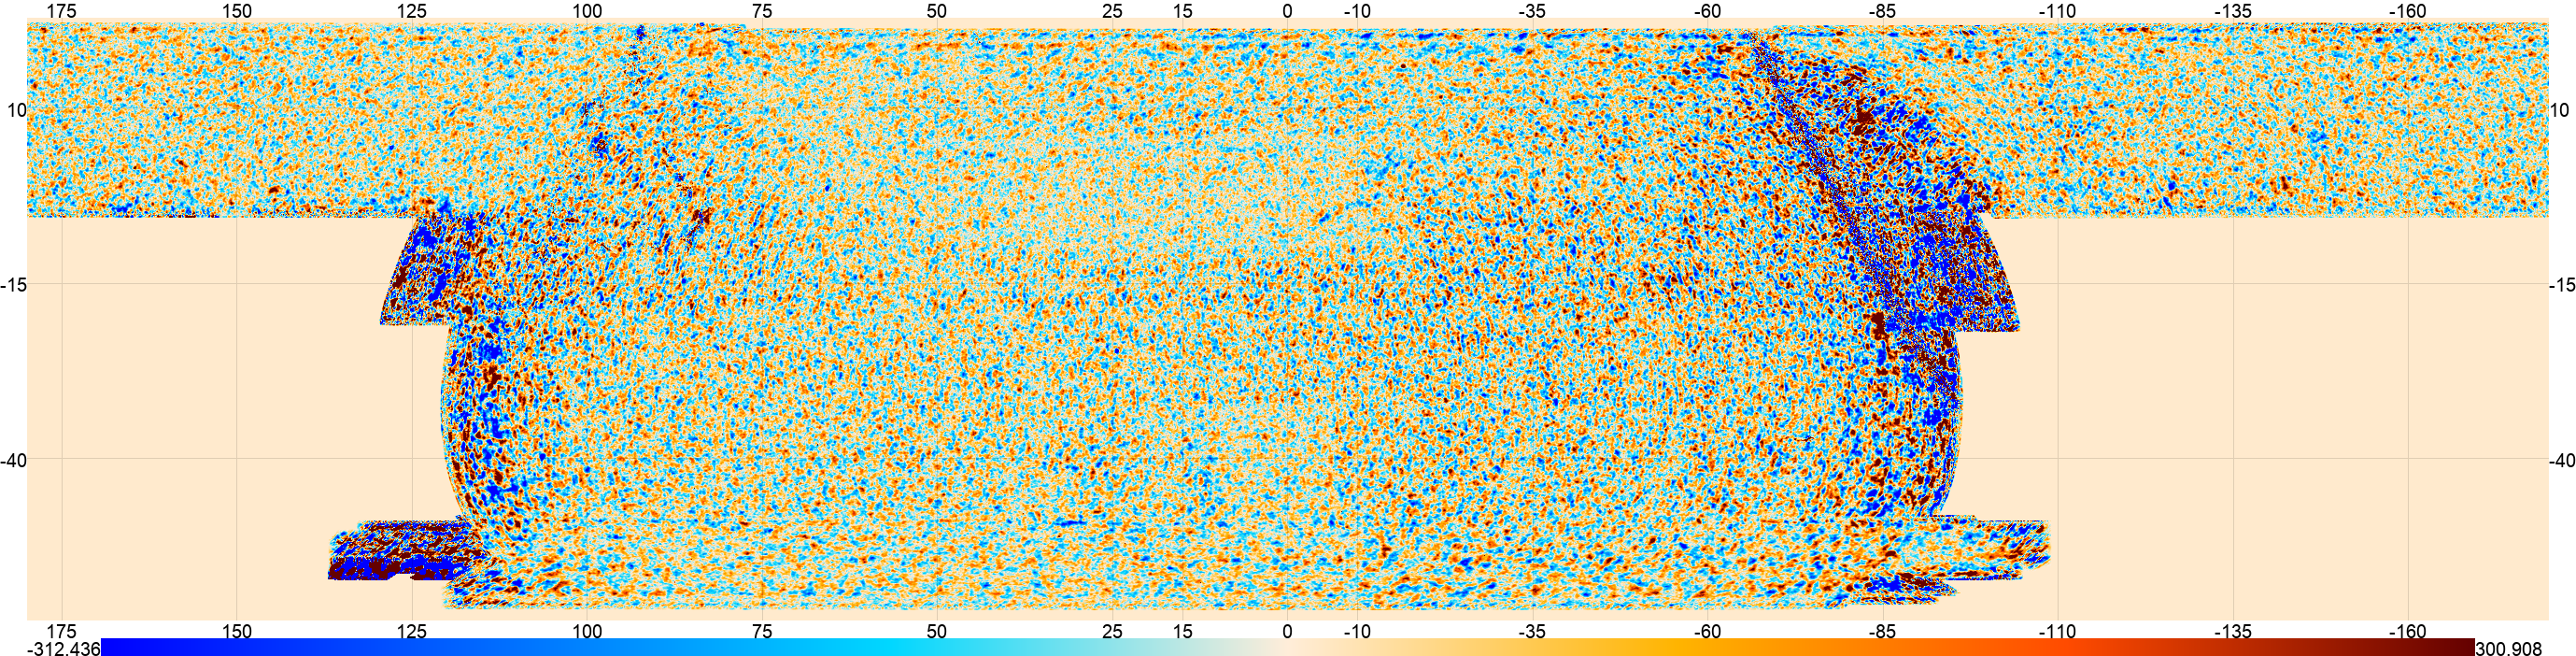

In [20]:
keys = {"downgrade": 16, "ticks": 25, "colorbar": True}
eshow(imap, **keys)

### Selecting a smaller patch of the sky

One of the advantages of using the CAR and Pixell framework is that you can easily select a small region of the map to examine in more detail.  Users can select a submap at a specific location by creating a bounding box around a central location in RA and DEC.  For example if we wanted to visualize an object at RA = 0 and dec = 0  we can create a box, with a width of 5 degrees, around this location.  Note that Pixell takes in bounding boxes in radians so here we convert the dec, ra and width to radians using numpy before forming the box.

You can also create a box using the framework:

> box = [[dec_from, ra_from],[dec_to, ra_to]] $\quad$ (in radians)

 

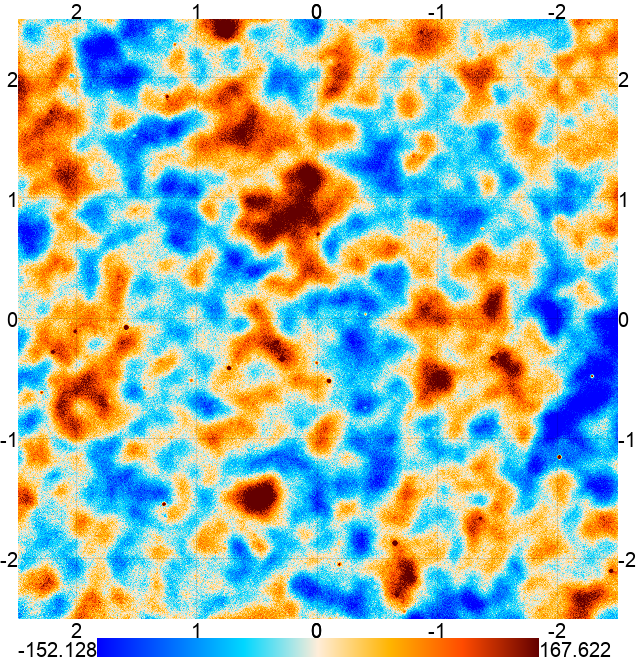

car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,7561]}

In [21]:
# Set up a box around dec = 0 and ra = 0
dec,ra = np.deg2rad([0,-0])

# Give the box a width of 5 degrees
width = np.deg2rad(5)

# Create the box and use it to select a submap
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
smap = imap.submap(box)

# Plot the map using the eshow function we defined earlier
eshow(smap, **{"colorbar":True})
imap.wcs

### Selecting a patch using pixel indexing
Alternatively we can slice the map using numpy array indexing to get a submap.  This will select a submap using the indexes of the pixels themselves instead of sky coordinates.  We will do that now for a larger area.  

What's useful about this is that you can treat the maps like a numpy array and pixell will automatically handle fixing the map projections as needed by adjusting the wcs information stored with the map.  If you look at the two wcs's printed after the map you can see the resolution stayed fixed but the center pixel adjusted when we cut the map.

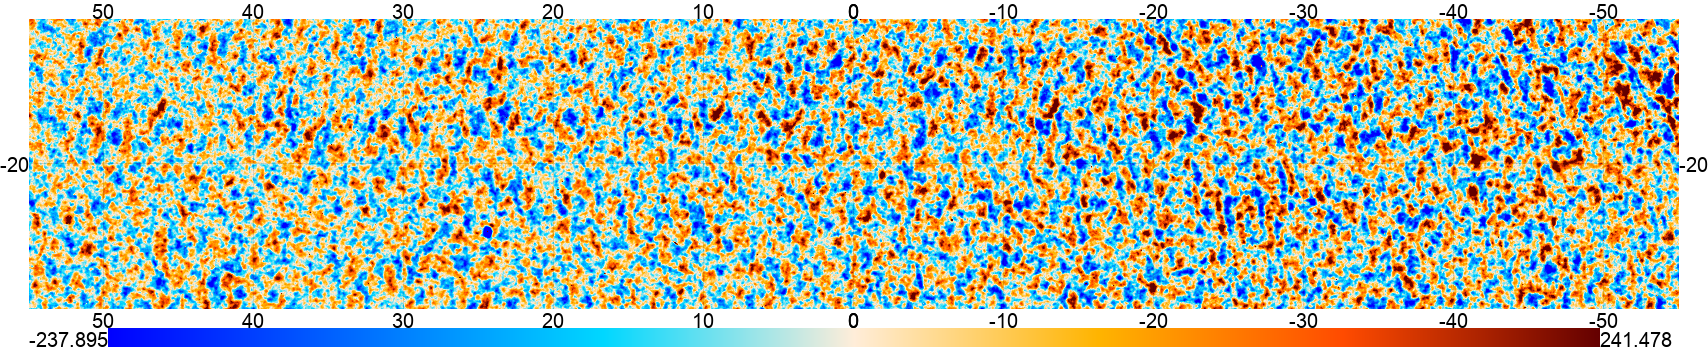

car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[2.16e+04,7561]}
car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[6601,3561]}


In [22]:
smap = imap[4000:-4000,15000:-15000]

eshow(smap, **{"downgrade": 8, "colorbar":True, "ticks": 10})

print(imap.wcs)
print(smap.wcs)

# Converting Between CAR and Healpix Maps

Pixell is designed to allow users to convert maps between HealPix format and ndmap format.  This is particularly useful for users interested in comparing maps readily available as HealPix maps to ACT maps.  The following code demonstrates a simple reprojection from one format to another.

When reprojecting it's helpful to keep in mind that Pixell automatically rotates maps from Planck's Galactic projection to Equatorial, if you are projecting a different map other rotations may be needed. 

Note that projections work by finding the spherical harmonic transformation of the healpix map to alm's and then inversely transforms the alm's to the rectangular pixel map geometry.  

Finally for anyone in looking at small patches of the sky we encourage you to use the maps in CAR format with Pixell as it enables users to reference patches in a way that Healpix can't do.


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/usr/local/lib/python3.6/dist-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/usr/local/lib/python3.6/dist-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


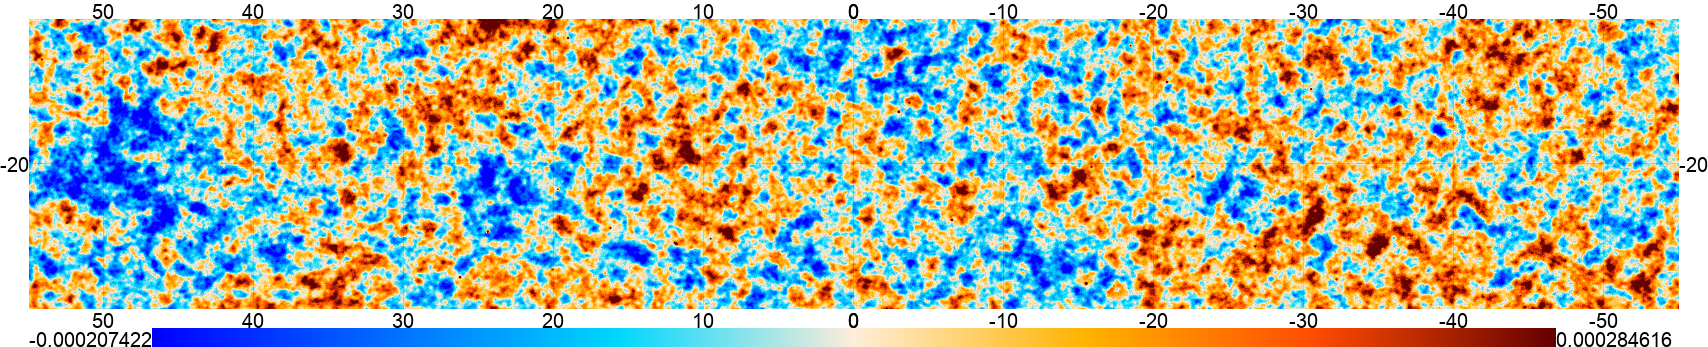

In [23]:
# Convert a planck HealPix map to ndmap
pmap_fname = path + "HFI_SkyMap_143_2048_R2.02_halfmission-1.fits"
planck_map = reproject.enmap_from_healpix(pmap_fname, smap.shape, smap.wcs, \
                                  ncomp=1, unit=1, lmax=6000,rot='gal,equ')
eshow(planck_map, **{"downgrade": 8, "colorbar":True, "ticks": 10, })

We can also take our trimmed ACT map and project it to the HealPix format using reproject as shown here.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


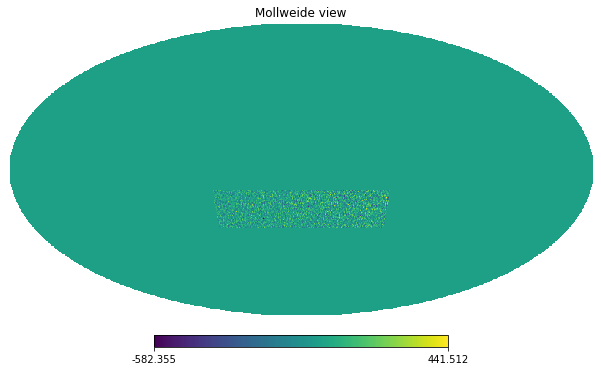

In [24]:
# Convert an ndmap map to HealPix

smap_healpix = reproject.healpix_from_enmap(smap, lmax = 6000, nside = 512)
hp.mollview(smap_healpix)

# Use a catalog to visualize objects in the map

In the above map it's already possible to see a few galaxy clusters just by visually examening the map.  However it would be great to be able to look at these more closely.  One option is to use a catalog of clusters and compare the catalog to the map.  In order to do so we need to get the RA and DEC of the relevant sources and then cut a box surrounding that location.

In [0]:
from astropy.io import fits

hdu = fits.open('/content/drive/My Drive/Pixell notebooks/E-D56Clusters.fits')
ras = hdu[1].data['RADeg']
decs = hdu[1].data['DECDeg']

One way to look at a source is to build another box and take a stamp.  Let's make the box slightly smaller this time in order to hone in on the objects we are interested in.  

This time we will use enplot's upgrade feature in order to plot a larger image of the object.

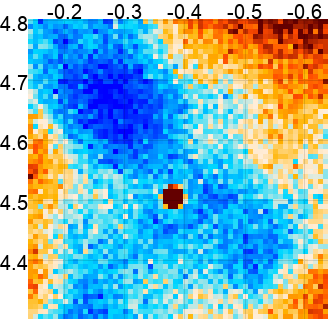

In [26]:
dec,ra = np.deg2rad([ras[12],decs[12]])
width = np.deg2rad(30./60.)

box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
stamp = imap.submap(box)

eshow(stamp, **{"upgrade": 5, "ticks": 0.1})

## Stacking point sources and using reproject

If we want to stack objects in the map it's relatively easy to do so but we need to use a slightly different approach.  Instead of using a bounding box and cutting a submap from the map we can use pixell's reproject.postage_stamp function to cut out postage stamps that are reprojected at the center of each object. 

Reprojecting means that we avoid stacking pointsources that are distorted due to the rectangular projection as it will automatically center the projection on each individual point source.

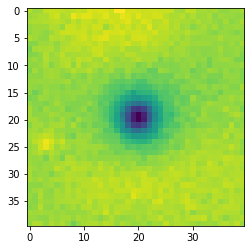

In [27]:
N = len(ras)
stack = 0

for i in range(N):
    # Extract stamps by reprojecting the map at the center of each source.
    # the 'postage_stamp' option here is designed to trim each reprojection so we
    # are left with a stack of point sources in a map of width 20 arc minutes
    stamp = reproject.postage_stamp(inmap = imap , ra_deg = ras[i], dec_deg = decs[i], width_arcmin = 20.,
                  res_arcmin = .5)
    if stamp is None: continue 
    stack += stamp[0]
    
stack /= N
plt.imshow(stack)